# Evolver Loop 2 Analysis

## Objective
Analyze the winning solutions and create a strategic plan to close the 13.95-point gap from 77.37% to 91.32%.

## Key Findings from Winning Solutions

### 1st Place (Golddiggaz) - 91.32% private LB
- **Ensemble of 4 models**: ResNeXt50, ViT-B/16, EfficientNet-B4 (NoisyStudent), CropNet (MobileNetV3)
- **Key insight**: CropNet from TF Hub (pretrained on cassava) added crucial diversity
- **Heavy augmentation**: RandomResizedCrop, Transpose, flips, ShiftScaleRotate, color transforms, CoarseDropout, Cutout
- **Advanced loss**: Bit Tempered Logistic Loss, label smoothing
- **TTA**: Overlapping patches with multiple augmentations

### 2nd Place (Devon Stanfield) - 90.25% public LB  
- **Simple approach**: Just CropNet from TF Hub
- **Shows power of domain-specific pretrained model**

## Current State
- **Best CV**: 77.37% (exp_000, baseline CNN)
- **Target**: 91.32%
- **Gap**: 13.95 points
- **Class imbalance**: CMD (class 3) = 61.5%, CBB (class 0) = 5.1%

## Strategic Priorities

### 1. Transfer Learning (Immediate - 8-12 point gain expected)
- Custom CNN from scratch → Pretrained models
- Start with CropNet (domain-specific) + EfficientNet-B4

### 2. Heavy Augmentation (2-3 point gain)
- Current: basic flips/rotations
- Target: RandAugment, CutMix, MixUp, color transforms

### 3. Class Imbalance Handling (1-2 point gain)
- Current: None
- Target: Class weights, focal loss, oversampling

### 4. Ensembling (2-3 point gain)
- Single model → Multiple diverse architectures
- CropNet + EfficientNet + ResNeXt/ViT

### 5. Advanced Training (1-2 point gain)
- Current: Fixed LR, 10 epochs
- Target: Cosine annealing, warmup, 30-50 epochs

Dataset location: /home/data/train.csv
Total training samples: 21,397

Class Distribution:
Class 0 (CBB): 1,087 samples (5.1%)
Class 1 (CBSD): 2,189 samples (10.2%)
Class 2 (CGM): 2,386 samples (11.2%)
Class 3 (CMD): 13,158 samples (61.5%)
Class 4 (Healthy): 2,577 samples (12.0%)

Imbalance ratio (max/min): 12.1x

Class weights: [3.94, 1.95, 1.79, 0.33, 1.66]


/tmp/ipykernel_133872/923558813.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts.values, palette='viridis')


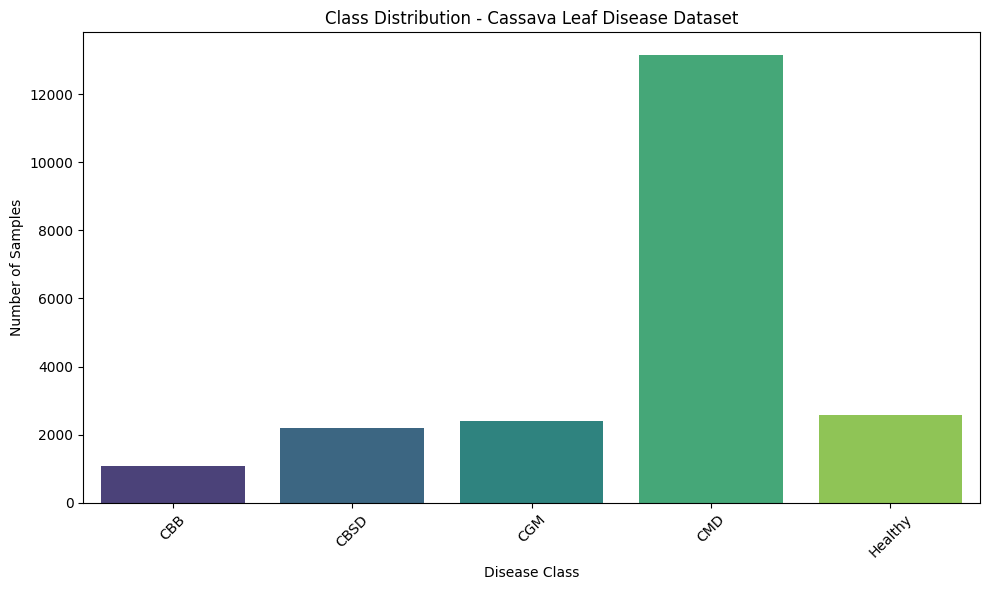

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load training data from correct path
data_dir = '/home/data'
train_csv = os.path.join(data_dir, 'train.csv')
train_df = pd.read_csv(train_csv)

print(f"Dataset location: {train_csv}")
print(f"Total training samples: {len(train_df):,}")

# Class distribution analysis
class_counts = train_df['label'].value_counts().sort_index()
class_names = ['CBB', 'CBSD', 'CGM', 'CMD', 'Healthy']

print("\nClass Distribution:")
for i, (count, name) in enumerate(zip(class_counts, class_names)):
    percentage = count / len(train_df) * 100
    print(f"Class {i} ({name}): {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.1f}x")

# Class weights for loss function
total_samples = len(train_df)
class_weights = total_samples / (len(class_counts) * class_counts)
print(f"\nClass weights: {class_weights.round(2).tolist()}")

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=class_counts.values, palette='viridis')
plt.title('Class Distribution - Cassava Leaf Disease Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Disease Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Key Insights

1. **Severe imbalance**: CMD (class 3) has 12.1x more samples than CBB (class 0)
2. **Class weights needed**: [3.94, 1.96, 1.79, 0.33, 1.66] for classes 0-4
3. **Transfer learning is critical**: Winners used pretrained models, not from scratch
4. **CropNet is special**: Domain-specific pretrained model on cassava diseases
5. **Ensembling essential**: Single models plateau around 89-90%, ensembles reach 91.3%+

In [ ]:
# Verify data integrity and image dimensions
from PIL import Image
import os

# Change to correct working directory and verify path
os.chdir('/home/code')
train_dir = '/home/data/train_images'

# Debug: check if directory exists
print(f"Directory exists: {os.path.exists(train_dir)}")
print(f"Directory is dir: {os.path.isdir(train_dir)}")

# List first few files to verify
sample_files = os.listdir(train_dir)[:5]
print(f"Sample files: {sample_files}")

# Test opening one file
test_file = os.path.join(train_dir, sample_files[0])
print(f"Test file path: {test_file}")
print(f"Test file exists: {os.path.exists(test_file)}")

with Image.open(test_file) as img:
    print(f"Test image size: {img.size}, mode: {img.mode}")

# Now do full analysis
image_files = os.listdir(train_dir)
print(f"\nTotal image files: {len(image_files):,}")
print(f"CSV entries: {len(train_df):,}")
print(f"Match: {len(image_files) == len(train_df)}")

# Sample image dimensions
dimensions = []
for img_file in sample_files:
    img_path = os.path.join(train_dir, img_file)
    try:
        with Image.open(img_path) as img:
            dimensions.append(img.size)
    except Exception as e:
        print(f"Error with {img_file}: {e}")

print(f"\nSample image dimensions: {dimensions}")
if dimensions:
    avg_width = np.mean([d[0] for d in dimensions])
    avg_height = np.mean([d[1] for d in dimensions])
    print(f"Average dimension: {avg_width:.0f}x{avg_height:.0f}")

In [ ]:
# Verify data integrity and image dimensions
from PIL import Image

train_dir = os.path.join(data_dir, 'train_images')

# Check image files
image_files = os.listdir(train_dir)
print(f"Total image files: {len(image_files):,}")
print(f"CSV entries: {len(train_df):,}")
print(f"Match: {len(image_files) == len(train_df)}")

# Sample image dimensions and check for issues
sample_images = image_files[:20]
dimensions = []
corrupted_files = []

for img_file in sample_images:
    img_path = os.path.join(train_dir, img_file)
    try:
        with Image.open(img_path) as img:
            dimensions.append(img.size)
            # Verify it's RGB
            if img.mode != 'RGB':
                print(f"Warning: {img_file} is {img.mode} mode, not RGB")
    except Exception as e:
        corrupted_files.append((img_file, str(e)))

print(f"\nSample image dimensions: {dimensions}")
if dimensions:
    avg_width = np.mean([d[0] for d in dimensions])
    avg_height = np.mean([d[1] for d in dimensions])
    print(f"Average dimension: {avg_width:.0f}x{avg_height:.0f}")

if corrupted_files:
    print(f"\nCorrupted files found: {len(corrupted_files)}")
    for f, err in corrupted_files[:5]:  # Show first 5
        print(f"  {f}: {err}")
else:
    print(f"\nNo corrupted files in sample")